In [1]:
from platform import python_version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.model_selection import KFold
from sksurv.metrics import concordance_index_censored
# custom scoring
from sklearn import metrics
from sklearn.inspection import permutation_importance
# split test and train
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# import library Bayesian Optimization
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical


# seed
RANDOM_STATE = 1776

# set seaborn theme
sns.set_theme()

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())

# adjust pandas display options to max
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# adjust pandas display options to ensure full display of content
pd.set_option('display.max_colwidth', None)

Numpy Version: 1.26.4
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.9.2
Python Version: 3.9.20


### Import Data

In [2]:
# full dataframe
df = pd.read_pickle("../Data/CleanFullLabelsML.pkl")

# data label
df_label = pd.read_pickle("../Data/colLabelML.pkl") 

# boolean
df_bool = pd.read_pickle("../Data/colBooleanML.pkl")

# nominal
df_nominal = pd.read_pickle("../Data/colNominalML.pkl")

# ordinal
df_ordinal = pd.read_pickle("../Data/colOrdinalML.pkl")

# numeric
df_numeric = pd.read_pickle("../Data/colNumericML.pkl")

# checking for duplicated column name
df.columns[df.columns.duplicated()]

Index([], dtype='object')

In [3]:
# df DataFrame
print(f"Orginal Data file Shape: {df.shape}")
print(f"Label(s) Data rows: {len(df_label)}")
print(f"Boolean(s) Data rows: {len(df_bool)}")
print(f"Ordinal(s) Data rows: {len(df_ordinal)}")
print(f"Nominal(s) Data rows: {len(df_nominal)}")
print(f"Numeric(s) Data rows: {len(df_numeric)}")

Orginal Data file Shape: (14856, 121)
Label(s) Data rows: 13
Boolean(s) Data rows: 9
Ordinal(s) Data rows: 15
Nominal(s) Data rows: 79
Numeric(s) Data rows: 18


In [4]:
def percentageNull(df):
    """
    Calculate percentage of NaN & NaN count
    """
    # calculate the percentage of non-null values for each column
    per_calc = pd.DataFrame(100 - (df.count() / len(df) * 100))
    
    # rename columns name
    per_calc.rename(columns={0: 'percentage'}, inplace=True)

    # add counter
    per_calc['NaNCount'] = df.isna().sum()
    
    # sort
    per_calc.sort_values(by='percentage', inplace=True, ascending=False)

    # 
    NanReturn = per_calc[per_calc.NaNCount != 0]
    
    return NanReturn


def removeColumn(data, col):
    """
    Remove unwanted columns
    """
    # display removed feature(s)
    print(f"\nRemoved Features:{col}\n")
    # display shape of DataFrame
    print(f"Total rows before: {data.shape[0]:,} & columns: {data.shape[1]:,}")
    
    # remove column
    data.drop(columns=col, axis=1, inplace=True)

    # reset index in place
    data.reset_index(drop=True, inplace=True)

    # display shape of DataFrame
    print(f"Total rows after: {data.shape[0]:,} & columns: {data.shape[1]:,}")

    return data


def removeRowUsingMask(data, removeColLst, colstr):
    # boolean mask
    mask = ~data[colstr].isin(removeColLst)
    
    # apply the mask to keep only rows where 'removeColLst'
    data = data[mask]
    
    # reset the index if needed
    data = data.reset_index(drop=True)

    # disply row removed msg
    print(f"Remove row(s) from df_{colstr} DataFrame.")

    return data


def removeHouseKeeping(data, removeColLst, dataBool, dataOrdinal, dataNominal, dataNumeric, dataLabel):
    """
    Run helper fuction for house keeping
    """
    # remove DataFrame data (house keeping)
    dataLabel = removeRowUsingMask(dataLabel, removeColLst, colstr='label')
    dataBool = removeRowUsingMask(dataBool, removeColLst, colstr='boolean')
    dataOrdinal = removeRowUsingMask(dataOrdinal, removeColLst, colstr='ordinal')
    dataNominal = removeRowUsingMask(dataNominal, removeColLst, colstr='nominal')
    dataNumeric = removeRowUsingMask(dataNumeric, removeColLst, colstr='numeric')
    
    # remove features
    data = removeColumn(data, removeColLst)

    return data, dataBool, dataOrdinal, dataNominal, dataNumeric, dataLabel


def datatypeDF(data, databool, datanominal, dataordinal, datanumeric):    
    # initialize variables for all the column name per each datatype
    boolCol = databool.boolean.to_list()
    nominalCol = datanominal.nominal.to_list()
    ordinalCol = dataordinal.ordinal.to_list()
    numericCol = datanumeric.numeric.to_list()

    print('Total Data feature count: ', df.shape[1])
    print(f"\nBoolean feature count: {len(boolCol)}")
    print(f"Nominal feature count: {len(nominalCol)}")
    print(f"Ordinal feature count: {len(ordinalCol)}")
    print(f"Numeric feature count: {len(numericCol)}")
    print('\nTotal feature count: ' ,len(boolCol) + len(nominalCol) + len(ordinalCol) + len(numericCol))

    # return list for each type
    return boolCol, nominalCol, ordinalCol, numericCol


In [5]:
# display NaNs
DFNaN = percentageNull(df)

# display
DFNaN.head(15)

,percentage,NaNCount


In [6]:
df_label

,label
0,FollowUpFunctionalStatus_CAN
1,AirwayDehiscencePostTransplant_CAN
2,AcuteRejectionEpisode_CAN
3,StrokePostTransplant_CAN
4,PacemakerPostTransplant_CAN
5,GraftFailed_CAN
6,LastFollowupNumber_CAN
7,TransplantStatus_CAN
8,TransplantSurvivalDay_CAN
9,RecipientStatus_CAN


In [7]:
# select label for classification
removeCol = df_label.label.to_list()

# remove GraftFailed_CAN
removeCol.remove('TransplantStatus_CAN')
removeCol.remove('TransplantSurvivalDay_CAN')

# remove unwanted features
df, df_bool, df_ordinal, df_nominal, df_numeric, df_label = removeHouseKeeping(df, removeCol, df_bool, df_ordinal, df_nominal, df_numeric, df_label)

Remove row(s) from df_label DataFrame.
Remove row(s) from df_boolean DataFrame.
Remove row(s) from df_ordinal DataFrame.
Remove row(s) from df_nominal DataFrame.
Remove row(s) from df_numeric DataFrame.

Removed Features:['FollowUpFunctionalStatus_CAN', 'AirwayDehiscencePostTransplant_CAN', 'AcuteRejectionEpisode_CAN', 'StrokePostTransplant_CAN', 'PacemakerPostTransplant_CAN', 'GraftFailed_CAN', 'LastFollowupNumber_CAN', 'RecipientStatus_CAN', 'RejectionTreatmentWithinOneYear_CAN', 'GraftStatus_CAN', 'LengthOfStay_CAN']

Total rows before: 14,856 & columns: 121
Total rows after: 14,856 & columns: 110


In [8]:
# describe
df[['TransplantStatus_CAN','TransplantSurvivalDay_CAN']].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
TransplantStatus_CAN,14856,2,False,13005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TransplantSurvivalDay_CAN,14856.0,NaN,NaN,NaN,634.23371,473.942355,0.0,194.0,606.0,1084.0,1799.0


In [9]:
# import library to create a structured array for survival analysis data
from sksurv.util import Surv

# rename columns
df = df.rename(columns={'TransplantStatus_CAN': 'status', 'TransplantSurvivalDay_CAN': 'time'})

# prepare the survival data
y = Surv.from_dataframe('status', 'time', df)
X = df.drop(columns=['status', 'time'])

In [10]:
type(y)

numpy.ndarray

In [11]:
# initialize list with feature names
boolCol, nominalCol, ordinalCol, numericCol = datatypeDF(X, df_bool, df_nominal, df_ordinal, df_numeric)

Total Data feature count:  110

Boolean feature count: 9
Nominal feature count: 69
Ordinal feature count: 15
Numeric feature count: 17

Total feature count:  110


### Encode

In [12]:
# remove from list
boolCol.remove('TransplantStatus_CAN')
numericCol.remove('TransplantSurvivalDay_CAN')

#### Split Testing & Validation & Training

In [13]:
def EncodeDummyScaleTrainValTest(Xdata, ydata, nominalColumns, numericColumns, seed=RANDOM_STATE):

    # dummy Encoding
    df_encoded = pd.get_dummies(Xdata, columns=nominalColumns, drop_first=True)
    
    # split the dataset into 80% training and 20% testing
    X_train, X_test, y_train, y_test = train_test_split(df_encoded, ydata, test_size=0.2, random_state=seed, stratify=y['status'])
    
    # split train data into validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed, stratify=y_train['status'])

    # initialize scaling
    scaler = MinMaxScaler()

    # fit model
    fit = scaler.fit(X_train[numericColumns])

    # transform
    # X_train[numericColumns] = fit.transform(X_train[numericColumns])
    # X_val[numericColumns] = fit.transform(X_val[numericColumns])
    # X_test[numericColumns] = fit.transform(X_test[numericColumns])
    
    # display shape
    print(f"Training Dependent Shape: {X_train.shape} & Label Shape: {y_train.shape}")
    print(f"Validation Dependent Shape: {X_val.shape} & Label Shape: {y_val.shape}")
    print(f"Testing Dependent Shape: {X_test.shape} & Label Shape: {y_test.shape}")

    return  X, y, X_train, X_test, X_val, y_train, y_val, y_test

In [14]:
# split dataset
X, y, X_train, X_test, X_val, y_train, y_val, y_test = EncodeDummyScaleTrainValTest(X, y, nominalCol, numericCol, RANDOM_STATE)

Training Dependent Shape: (9507, 204) & Label Shape: (9507,)
Validation Dependent Shape: (2377, 204) & Label Shape: (2377,)
Testing Dependent Shape: (2972, 204) & Label Shape: (2972,)


In [15]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
PreviousTransplantNumber_CAN,9507.0,0.031135,0.181973,0.000000,0.000000,0.000000,0.000000,2.000000
EducationLevel_CAN,9507.0,3.841380,1.262464,0.000000,3.000000,4.000000,5.000000,6.000000
TotalDayWaitList_CAN,9507.0,4.032725,1.721373,0.000000,2.639057,3.988984,5.413873,8.252185
PreTransplantMedicalCondition_CAN,9507.0,2.045756,0.928492,0.000000,1.000000,2.000000,3.000000,3.000000
MismatchLevel_LOCUS,9507.0,2.246555,0.901647,0.000000,2.000000,2.000000,3.000000,3.000000
MismatchLevel_B_LOCUS,9507.0,2.475124,0.891486,0.000000,2.000000,3.000000,3.000000,3.000000
MismatchLevel_DR_LOCUS,9507.0,2.285895,0.897019,0.000000,2.000000,3.000000,3.000000,3.000000
MismatchLevel_HLA,9507.0,5.176502,1.875738,0.000000,5.000000,6.000000,6.000000,7.000000
BloodUreaNitrogenLevel_DON,9507.0,3.130375,0.620870,0.693147,2.708050,3.091042,3.496508,5.509388
DiabetesHistory_DON,9507.0,1.086778,0.532690,0.000000,1.000000,1.000000,1.000000,5.000000


#### Evaluation Functions for Survival Analysis

In [16]:
# evaluation function
def evaluate_model(model, Xdata, ydata):
    pred = model.predict(Xdata)
    return concordance_index_censored(ydata['status'], ydata['time'], pred)[0]

def SurvivalAnalysisCompare(models, model_names):
    for model, name in zip(models, model_names):
        train_cindex = evaluate_model(model, X_train, y_train)
        val_cindex = evaluate_model(model, X_val, y_val)
        test_cindex = evaluate_model(model, X_test, y_test)
        print(f"{name} - Train C-index: {train_cindex:.4f}, Validation C-index: {val_cindex:.4f}, Test C-index: {test_cindex:.4f}")

In [17]:
from sksurv.metrics import cumulative_dynamic_auc

def CumulativeDynamicAUC(model, Xtrain, Xval, Xtest, ytrain, yval, ytest, Type):
    """
    Cumulative Dynamic Area Under the Curve (cumulative_dynamic_auc) is a performance metric used in time-to-event 
    (survival) analysis. It evaluates the ability of a survival model to discriminate between individuals who 
    experience an event at a given time and those who do not, across various time points.
    
    """
    # predictions
    train_pred = model.predict(Xtrain)
    val_pred = model.predict(Xval)
    test_pred = model.predict(Xtest)
    
    # creating 20 percentile points between the 5th and 95th percentiles of data. 
    # creating a range of evaluation points that cover most of the data while avoiding extreme values.
    times = np.percentile(ytrain['time'][ytrain['status']], np.linspace(5, 95, 20))

    # Cumulative Dynamic Area Under the Curve
    auc_train, mean_auc_train = cumulative_dynamic_auc(ytrain, ytrain, train_pred, times)
    auc_val, mean_auc_val = cumulative_dynamic_auc(ytrain, yval, val_pred, times)
    auc_test, mean_auc_test = cumulative_dynamic_auc(ytrain, ytest, test_pred, times)
    
    # plot
    plt.figure(figsize=(10, 6))
    plt.plot(times, auc_train, marker='o', label='Training')
    plt.plot(times, auc_val, marker='o', label='Validation')
    plt.plot(times, auc_test, marker='o', label='Testing')
    plt.xlabel('Time')
    plt.ylabel('Time-dependent AUC')
    plt.title(f'Time-dependent AUC {Type}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # display
    print(f"Mean AUC (train): {mean_auc_train:.4f}")
    print(f"Mean AUC (validation): {mean_auc_val:.4f}")
    print(f"Mean AUC (test): {mean_auc_test:.4f}")

In [18]:
def fit_and_score_features(Xdata, ydata, alpha=0.1):
    """
    Each feature is scored individually, the scores do not account for 
    interactions or multicollinearity between features.
    """
    # the number of features
    n_features = Xdata.shape[1]
    # empty array to store scores for each feature
    scores = np.empty(n_features)
    # initializes a Cox model with the specified alpha
    m = CoxPHSurvivalAnalysis(alpha=alpha)
    for j in range(n_features):
        Xj = Xdata[:, j : j + 1]       # selects a single feature 
        m.fit(Xj, ydata)               # fits the Cox model using only this feature
        scores[j] = m.score(Xj, ydata) # calculates and stores the model's score for this feature
    return scores

In [19]:
# feature selection
scores = fit_and_score_features(X_train.values, y_train)
pd.Series(scores, index=X_train.columns).sort_values(ascending=False)

IschemicTimeHours_DON                                    0.560668
PriorCardiacSurgery_CAN_Y                                0.553804
TotalBilirubin_Addition                                  0.541776
Diabetes_CAN_Yes                                         0.534394
CoronaryAngiogram_DON_Unknown                            0.530750
HeightCm_Difference                                      0.526301
Transfusion_CAN_Y                                        0.523782
CoronaryAngiogram_DON_Normal                             0.522452
RiskHIV_DON_Y                                            0.521946
CigaretteUse_CAN_Y                                       0.521339
MismatchLevel_DR_LOCUS                                   0.518880
DistanceFrom_HospitaltoTXCenter                          0.518465
Creatinine_Difference                                    0.518172
DialysisAfterList_CAN_Y                                  0.517548
Hypertension_DON_Y                                       0.517261
Bronchosco

In [20]:
# model
model = CoxPHSurvivalAnalysis(alpha=0.15014805617018961, n_iter=500, ties='efron')

# fit model
ModelCHP = model.fit(X_train, y_train)

# model score
SurvivalAnalysisCompare([ModelCHP], ['CoxPHSurvivalAnalysis'])

CoxPHSurvivalAnalysis - Train C-index: 0.6696, Validation C-index: 0.5987, Test C-index: 0.6197


#### Log Hazard Ratio Interpretation:
    - Interpretation of Coefficients:
        - Each coefficient quantifies the effect of a one-unit increase in the corresponding predictor on the hazard ratio.
        - A positive coefficient indicates that an increase in the predictor is associated with an increased hazard, meaning a higher risk of the event occurring.
        - A negative coefficient suggests that an increase in the predictor is associated with a decreased hazard, indicating a lower risk of the event.
- The hazard ratio (HR) for a covariate is given by: $\huge{HR}_{i} = {e}^{\beta_i}$

In [72]:
# get the coefficients & feature names
coefficients = ModelCHP.coef_
feature_names = ModelCHP.feature_names_in_

# create a DataFrame to display coefficients and feature names
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'AbsCoefficient': np.abs(coefficients),
    'Hazard_Ratio': np.exp(coefficients)
    
})

coefficients_df.sort_values(by='AbsCoefficient', ascending=False).head(10)

,Feature,Coefficient,AbsCoefficient,Hazard_Ratio
203,ResultNAT_DON_Combined_Unknown,-2.359277,2.359277,0.094489
90,SurfaceAntigenHEP_B_DON_Unknown,-1.841062,1.841062,0.158649
89,SurfaceAntigenHEP_B_DON_Positive,-1.771785,1.771785,0.170029
45,SerologyAntiCMV_DON_Unknown,-1.694381,1.694381,0.183713
92,Triiodothyronine_T3_DON_Y,-1.522956,1.522956,0.218066
74,Hepatitis_B_CoreAntibody_DON_Unknown,1.489692,1.489692,4.435731
67,LV_EjectionFractionMedthod_DON_Unknown,-1.450830,1.450830,0.234376
22,BloodPH_DON,-1.418551,1.418551,0.242065
119,Biopsy_DON_Needle,-1.391058,1.391058,0.248812
120,Biopsy_DON_Unknown,-1.316919,1.316919,0.267960


In [73]:
coefficients_df.sort_values(by='AbsCoefficient', ascending=False).tail(10)

,Feature,Coefficient,AbsCoefficient,Hazard_Ratio
33,AntigenC1_C2_CAN_Addition,0.002574,0.002574,1.002577
146,DeathMechanism_DON_GUNSHOT WOUND,0.002191,0.002191,1.002193
30,WeightKg_Difference,-0.001462,0.001462,0.998539
25,Age_Difference,-0.001093,0.001093,0.998908
28,Hemodynamics_CAN_Addition,-0.000774,0.000774,0.999227
19,LV_EjectionFractionPercent_DON,-0.000678,0.000678,0.999322
37,Total_AntigenHist_DON,-0.000481,0.000481,0.999519
24,PF_Ratio_DON,0.000425,0.000425,1.000425
36,Total_AntigenHLA,-0.000146,0.000146,0.999854
134,NonHeartBeating_DON_U,0.000000,0.000000,1.000000


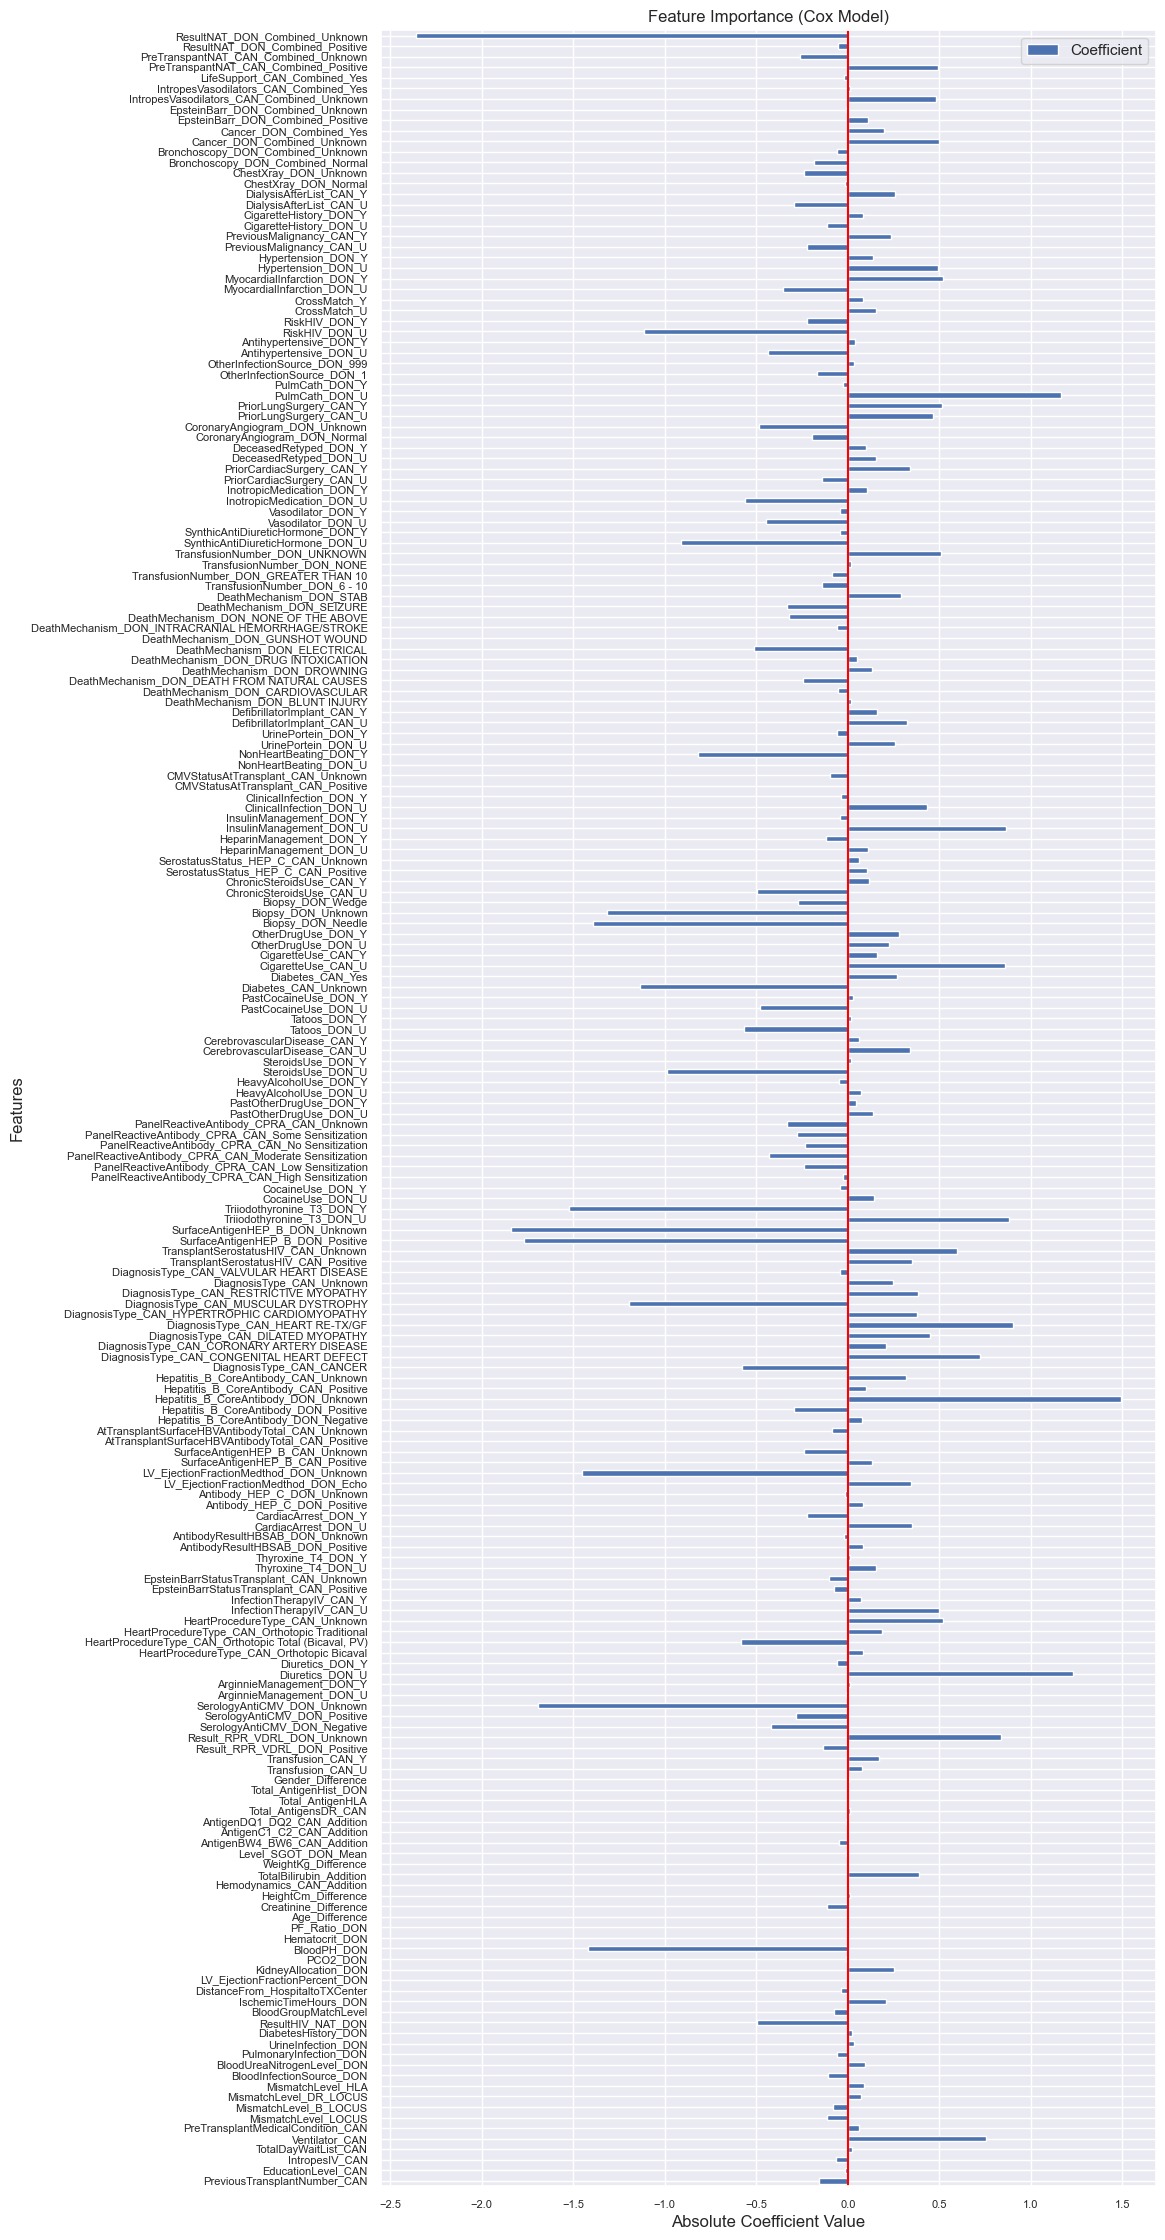

In [74]:
# plot feature importance
coefficients_df.plot(kind='barh', x='Feature', y='Coefficient', figsize=(10, 28), title="Feature Importance (Cox Model)", fontsize=8)
plt.axvline(0, color='red', linestyle='-')
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Features")
plt.show()

#### Determine if a Cox Proportional Hazards (CoxPH) model is good and fits the assumptions
1. Check Proportional Hazards Assumption
    - The Cox model assumes that the hazard ratios are constant over time.  

In [95]:
# combined into a DataFrame
train_data = pd.concat([X_train.reset_index(drop=True), pd.DataFrame(y_train)], axis=1)

# identify and drop low variance columns
low_variance_cols = [col for col in train_data.columns if train_data[col].var() < 0.01]
print("Low Variance Columns:", low_variance_cols)
train_data = train_data.drop(columns=low_variance_cols)

Low Variance Columns: ['ResultHIV_NAT_DON', 'BloodPH_DON', 'Transfusion_CAN_U', 'Result_RPR_VDRL_DON_Positive', 'Result_RPR_VDRL_DON_Unknown', 'SerologyAntiCMV_DON_Unknown', 'ArginnieManagement_DON_U', 'Diuretics_DON_U', 'HeartProcedureType_CAN_Unknown', 'InfectionTherapyIV_CAN_U', 'Thyroxine_T4_DON_U', 'Antibody_HEP_C_DON_Unknown', 'LV_EjectionFractionMedthod_DON_Unknown', 'Hepatitis_B_CoreAntibody_DON_Unknown', 'DiagnosisType_CAN_CANCER', 'DiagnosisType_CAN_MUSCULAR DYSTROPHY', 'TransplantSerostatusHIV_CAN_Positive', 'SurfaceAntigenHEP_B_DON_Positive', 'SurfaceAntigenHEP_B_DON_Unknown', 'Triiodothyronine_T3_DON_U', 'Triiodothyronine_T3_DON_Y', 'SteroidsUse_DON_U', 'CerebrovascularDisease_CAN_U', 'Tatoos_DON_U', 'Diabetes_CAN_Unknown', 'CigaretteUse_CAN_U', 'Biopsy_DON_Needle', 'Biopsy_DON_Unknown', 'Biopsy_DON_Wedge', 'ChronicSteroidsUse_CAN_U', 'HeparinManagement_DON_U', 'InsulinManagement_DON_U', 'ClinicalInfection_DON_U', 'NonHeartBeating_DON_U', 'UrinePortein_DON_U', 'DeathMechan

In [97]:
df.ResultHIV_NAT_DON.var()

0.0005382492074255047

In [98]:
df['ResultHIV_NAT_DON'].unique()

array([False,  True])

In [100]:
df['ResultHIV_NAT_DON'].value_counts()

ResultHIV_NAT_DON
False    14848
True         8
Name: count, dtype: int64

In [96]:
# import library
from lifelines import CoxPHFitter

# Fit the Cox model
cph = CoxPHFitter()
cph.fit(train_data, duration_col='time', event_col='status')

ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.

In [93]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# combined into a DataFrame
train_data = pd.concat([X_train.reset_index(drop=True), pd.DataFrame(y_train)], axis=1)

# identify and drop low variance columns
low_variance_cols = [col for col in train_data.columns if train_data[col].var() < 0.01]
print("Low Variance Columns:", low_variance_cols)
train_data = train_data.drop(columns=low_variance_cols)

# calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = train_data.columns
vif_data["VIF"] = [variance_inflation_factor(train_data.values, i) for i in range(train_data.shape[1])]

# Display features with high VIF
print(vif_data[vif_data["VIF"] > 5])  # Adjust threshold as necessary

Low Variance Columns: ['ResultHIV_NAT_DON', 'BloodPH_DON', 'Transfusion_CAN_U', 'Result_RPR_VDRL_DON_Positive', 'Result_RPR_VDRL_DON_Unknown', 'SerologyAntiCMV_DON_Unknown', 'ArginnieManagement_DON_U', 'Diuretics_DON_U', 'HeartProcedureType_CAN_Unknown', 'InfectionTherapyIV_CAN_U', 'Thyroxine_T4_DON_U', 'Antibody_HEP_C_DON_Unknown', 'LV_EjectionFractionMedthod_DON_Unknown', 'Hepatitis_B_CoreAntibody_DON_Unknown', 'DiagnosisType_CAN_CANCER', 'DiagnosisType_CAN_MUSCULAR DYSTROPHY', 'TransplantSerostatusHIV_CAN_Positive', 'SurfaceAntigenHEP_B_DON_Positive', 'SurfaceAntigenHEP_B_DON_Unknown', 'Triiodothyronine_T3_DON_U', 'Triiodothyronine_T3_DON_Y', 'SteroidsUse_DON_U', 'CerebrovascularDisease_CAN_U', 'Tatoos_DON_U', 'Diabetes_CAN_Unknown', 'CigaretteUse_CAN_U', 'Biopsy_DON_Needle', 'Biopsy_DON_Unknown', 'Biopsy_DON_Wedge', 'ChronicSteroidsUse_CAN_U', 'HeparinManagement_DON_U', 'InsulinManagement_DON_U', 'ClinicalInfection_DON_U', 'NonHeartBeating_DON_U', 'UrinePortein_DON_U', 'DeathMechan

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [94]:
# import library
from lifelines import CoxPHFitter

# Fit the Cox model
cph = CoxPHFitter()
cph.fit(train_data, duration_col='time', event_col='status')

ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.

In [110]:
from sksurv.metrics import brier_score

def calculate_mean_brier_score(model, Xdata, ydata):
    """
    Define a function to calculate the mean Brier score
    """
    # get each value
    event_times = ydata['time']
    event_observed = ydata['status']
    surv_pred = model.predict_survival_function(Xdata)
    time_points = np.linspace(0, max(event_times), 100)
    brier_scores = brier_score(surv_pred, event_times, event_observed, time_points)
    # Return score
    return np.mean(brier_scores)

#### Random Survival Forest

In [104]:
def FeatureImportanceRSF(model, Xtrain, Xval, ytrain, yval, nRepeats = 10, seed=RANDOM_STATE):
    
    # Fit the Random Survival Forest model
    fit = model.fit(Xtrain, ytrain)
    
    # Calculate permutation importance
    perm_importance = permutation_importance(fit, Xval, yval, n_repeats=nRepeats, random_state=seed)
    
    # Create a DataFrame with the feature importances
    feature_names = Xtrain.columns  # Assuming X_train is a DataFrame with column names
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': perm_importance.importances_mean
    })
    
    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # Plot the permutation feature importances with feature names
    plt.figure(figsize=(20, 10))
    plt.bar(importance_df['Feature'], importance_df['Importance'])
    plt.title('Random Survival Forest Feature Importances (Permutation)')
    plt.xlabel('Feature')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=90, fontsize=6)

    # Add feature names to the x-axis
    feature_names = Xtrain.columns
    plt.xticks(range(Xtrain.shape[1]), feature_names, rotation=90, fontsize=6)
    
    plt.tight_layout() 
    plt.show()
    
    # Return the DataFrame
    return importance_df

In [105]:
# instantiate RandomSurvivalForest (oob_score: whether to use out-of-bag samples to estimate the generalization accuracy.)
model = RandomSurvivalForest(max_depth=4, max_features=0.0857814230845138, min_samples_split=38, n_estimators=88, random_state=RANDOM_STATE, n_jobs=-1, oob_score=True)

# fit the model
fitModelRSF = model.fit(X_train, y_train)

In [106]:
# evaluate models
models = [fitModelRSF]
model_names = ['Random Survival Forest']

# evaluate
SurvivalAnalysisCompare(models, model_names)

Random Survival Forest - Train C-index: 0.6992, Validation C-index: 0.6400, Test C-index: 0.6124


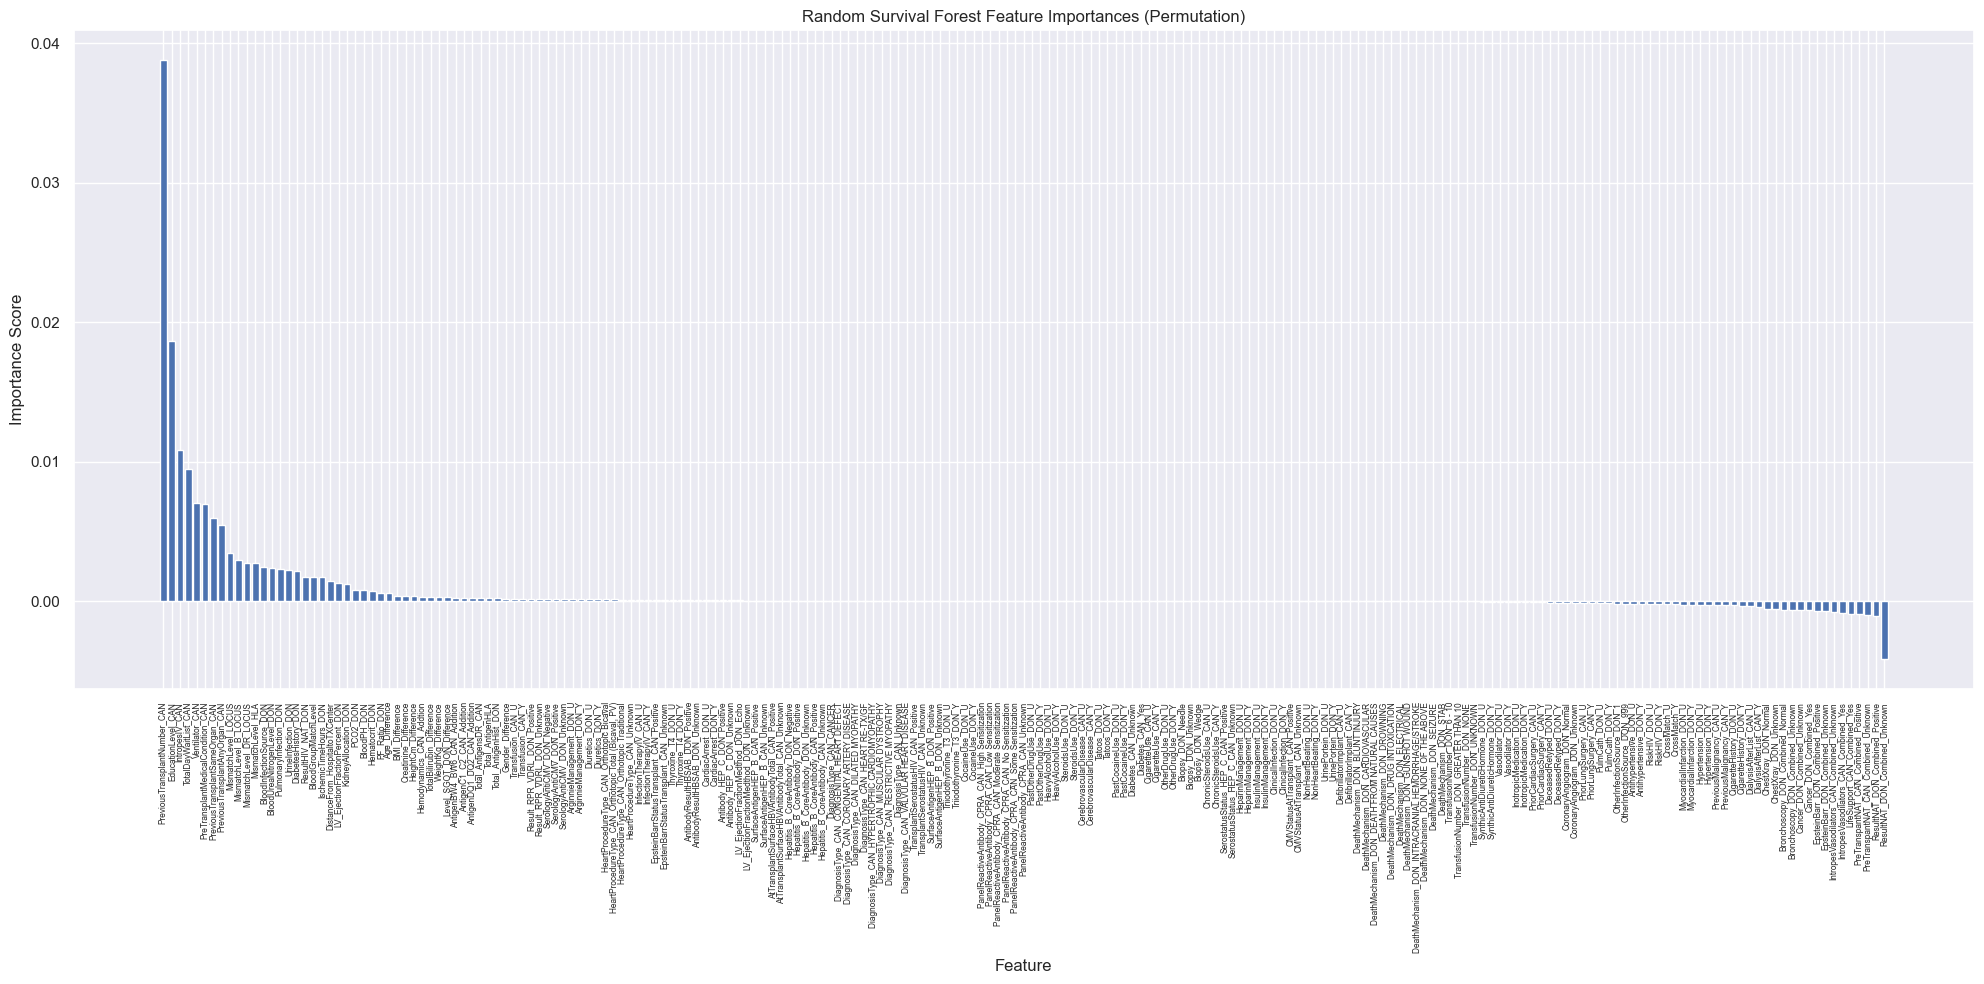

In [107]:
df_RSF = FeatureImportanceRSF(fitModelRSF, X_train, X_val, y_train, y_val, nRepeats = 5, seed=RANDOM_STATE)

In [108]:
df_RSF.head(10)

,Feature,Importance
165,PriorCardiacSurgery_CAN_Y,0.038770
32,TotalBilirubin_Difference,0.018649
19,IschemicTimeHours_DON,0.010807
117,Diabetes_CAN_Yes,0.009476
30,HeightCm_Difference,0.007022
43,Transfusion_CAN_Y,0.006986
29,Creatinine_Difference,0.005979
169,CoronaryAngiogram_DON_Unknown,0.005446
26,PF_Ratio_DON,0.003467
28,BMI_Difference,0.002947


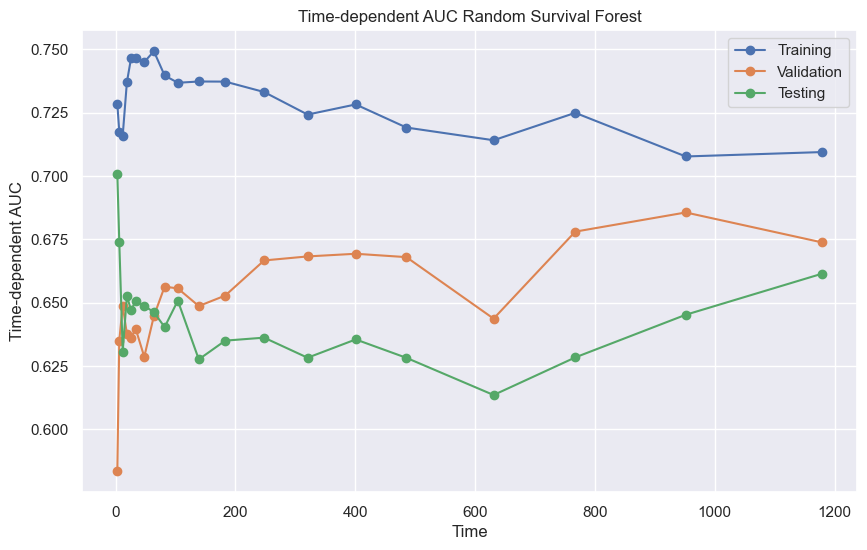

Mean AUC (train): 0.7259
Mean AUC (validation): 0.6576
Mean AUC (test): 0.6424


In [109]:
CumulativeDynamicAUC(fitModelRSF, X_train, X_val, X_test, y_train, y_val, y_test, 'Random Survival Forest')

In [80]:
surv_pred = fitModelRSF.predict_survival_function(X_val)

In [81]:
surv_pred = fitModelRSF.predict_survival_function(X_test)

# Define the time points at which to calculate the Brier score
time_points = np.linspace(0, max(y_test['time']), 100)

# Create the estimate array
estimate = np.array([[fn(t) for t in time_points] for fn in surv_pred])

In [83]:
brier_score(y_train, y_test, estimate, time_points)

ValueError: all times must be within follow-up time of test data: [0.0; 1680.0[